In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, LambdaCallback
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import argparse
import cv2
import os

In [0]:
# Setting the dataset paths
dataset = '/content/'

""" Look over the images in our dataset 
and then initialize our data and labels list
"""

imagePaths = list(paths.list_images(dataset))
data = []
labels = []

# Loop over the image paths
for imagePath in imagePaths:

    # Extract the class label from the file path (covid19 or no_covid19)
    label = imagePath.split(os.path.sep)[-2]
    """ 
    Load the image, swap color channels, and resize it to be a fixed
    224x224 pixels while ignoring aspect ratio . This will make the images
    equal in size so that they are ready for our CNN
    """
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # Update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
 
""" 
Convert the data and labels to NumPy arrays while scaling the pixel
intensities to the range [0, 1] 
"""
data = np.array(data) / 255.0
labels = np.array(labels)

In [0]:
print(labels)

['covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19'
 'covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19'
 'covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19' 'covid19'
 'covid19' 'covid19' 'covid19' 'covid19' 'no_covid19' 'no_covid19'
 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19'
 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19'
 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19'
 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19' 'no_covid19'
 'no_covid19' 'no_covid19' 'no_covid19']


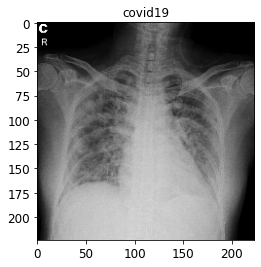

In [0]:
plt.title(labels[1])
plt.imshow(data[1])

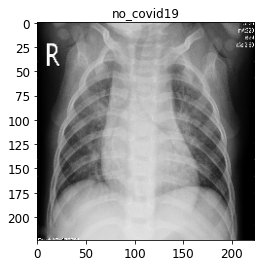

In [0]:
plt.title(labels[27])
plt.imshow(data[27])

In [0]:
data[1].shape

(224, 224, 3)

In [0]:
labels.shape

(50,)

In [0]:
data.shape

(50, 224, 224, 3)

In [0]:
from skimage import io, color

In [0]:
lina_gray = color.rgb2gray(data)

In [0]:
lina_gray.shape

(50, 224, 224)

In [0]:
data = lina_gray

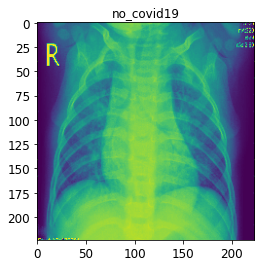

In [0]:
plt.title(labels[27])
plt.imshow(data[27])

In [0]:
from sklearn.mixture import GaussianMixture
import numpy as np

In [0]:
num_pixels = data.shape[1] * data.shape[2]
X_train_reshaped = data.reshape(data.shape[0], num_pixels).astype('float32')

X_train_reshaped.shape

(50, 50176)

In [0]:
#this shape is huge so before applying GMM to generate more instances, I will do a PCA
#remaining with 99% 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(X_train_reshaped)
data.shape

(50, 44)

In [0]:
data_recovered = pca.inverse_transform(data)

In [0]:
data_recovered.shape

(50, 50176)

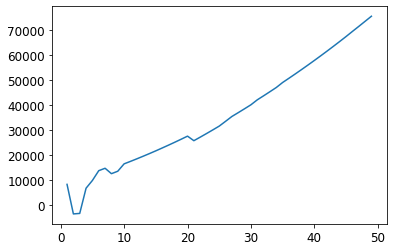

In [0]:
n_components = np.arange(1, 50, 1)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [0]:
gmm = GaussianMixture(2, covariance_type='full', random_state=0)
gmm.fit(data_recovered)
print(gmm.converged_)

In [0]:
data_new = gmm.sample(500)

In [0]:
data_new[0].shape

(500, 44)

In [0]:
data_new[0]

array([[-0.1981104 , -0.79708174, -0.43917044, ...,  0.10762556,
        -1.14017505,  1.00830333],
       [ 0.51250009,  1.0968674 ,  0.97081483, ..., -0.35332551,
        -0.21146384, -0.09021132],
       [-0.40174867,  0.0476817 , -1.15600364, ..., -1.49645282,
         0.31020299,  0.24208373],
       ...,
       [-0.95553186,  0.79991798,  0.4225869 , ...,  0.22369732,
         0.48192188,  1.14934284],
       [ 0.27139688, -1.02651999,  0.61740954, ..., -0.90561248,
         1.95357257, -1.0426883 ],
       [-0.59242416, -0.57573427,  0.29668754, ...,  0.29866985,
        -0.56971023,  0.21205757]])

In [0]:
data_new[1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [0]:
data_new[1].shape

(500,)

In [0]:
data_new[0][:400]

array([[-0.1981104 , -0.79708174, -0.43917044, ...,  0.10762556,
        -1.14017505,  1.00830333],
       [ 0.51250009,  1.0968674 ,  0.97081483, ..., -0.35332551,
        -0.21146384, -0.09021132],
       [-0.40174867,  0.0476817 , -1.15600364, ..., -1.49645282,
         0.31020299,  0.24208373],
       ...,
       [-0.06243371, -0.33041637,  0.96697289, ..., -1.09423467,
        -0.2287497 , -1.63627207],
       [-0.08329492, -2.66941076,  0.45930724, ..., -0.73575175,
        -0.13491265, -1.9402939 ],
       [ 0.21255317, -0.32385819,  0.82406353, ..., -1.32637716,
         0.04288543,  1.82654521]])

In [0]:
X_full = data_new[0]
y_full = data_new[1]

In [0]:
X_full.shape

(500, 44)

In [0]:
y_full.shape

(500,)

In [0]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)

In [0]:
X_train.shape

(320, 44)

In [0]:
X_valid.shape

(80, 44)

In [0]:
X_test.shape

(100, 44)

In [0]:
import tensorflow as tf
from tensorflow import keras

In [0]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[44]))
model.add(keras.layers.Dense(35, activation="relu"))
model.add(keras.layers.Dense(20, activation="relu"))
model.add(keras.layers.Dense(10, activation="relu"))
model.add(keras.layers.Dense(2, activation="sigmoid")) #sigmoid because is binary classification

In [0]:
model.layers

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 44)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 35)                1575      
_________________________________________________________________
dense_9 (Dense)              (None, 20)                720       
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 22        
Total params: 2,527
Trainable params: 2,527
Non-trainable params: 0
_________________________________________________________________


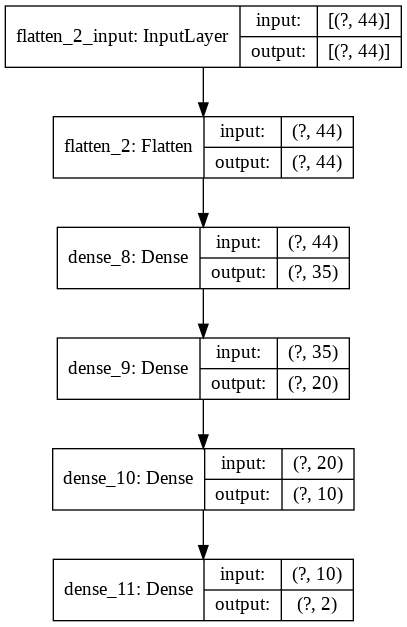

In [0]:
keras.utils.plot_model(model, "my_covid_model.png", show_shapes=True)

In [0]:
model.compile(loss="sparse_categorical_crossentropy", #this loss because is binary classification
              optimizer="Adam",
              metrics=["accuracy"])

In [0]:
history = model.fit(X_train, y_train, epochs=25,
                    validation_data=(X_valid, y_valid),)

Epoch 1/25
10/10 [==============================] - 0s 23ms/step - loss: 0.6752 - accuracy: 0.5750 - val_loss: 0.6447 - val_accuracy: 0.7375
Epoch 2/25
10/10 [==============================] - 0s 5ms/step - loss: 0.6355 - accuracy: 0.7000 - val_loss: 0.6105 - val_accuracy: 0.7750
Epoch 3/25
10/10 [==============================] - 0s 5ms/step - loss: 0.5957 - accuracy: 0.7688 - val_loss: 0.5688 - val_accuracy: 0.7750
Epoch 4/25
10/10 [==============================] - 0s 5ms/step - loss: 0.5465 - accuracy: 0.8125 - val_loss: 0.5180 - val_accuracy: 0.8500
Epoch 5/25
10/10 [==============================] - 0s 5ms/step - loss: 0.4860 - accuracy: 0.8719 - val_loss: 0.4583 - val_accuracy: 0.8750
Epoch 6/25
10/10 [==============================] - 0s 5ms/step - loss: 0.4137 - accuracy: 0.9219 - val_loss: 0.3890 - val_accuracy: 0.9125
Epoch 7/25
10/10 [==============================] - 0s 5ms/step - loss: 0.3291 - accuracy: 0.9563 - val_loss: 0.3064 - val_accuracy: 0.9625
Epoch 8/25
10/10 [=

Saving figure keras_learning_curves_plot


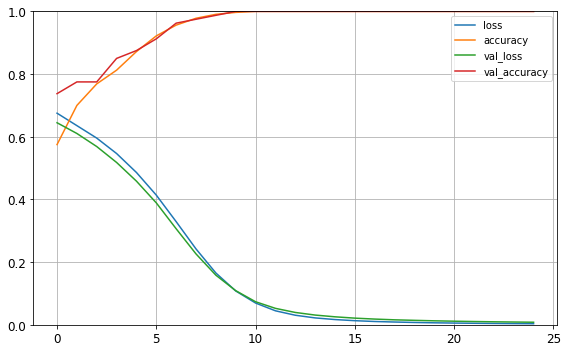

In [0]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot")
plt.show()

In [0]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0204 - accuracy: 1.0000


[0.020391028374433517, 1.0]

In [0]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(3)

array([[0.014, 0.033],
       [0.109, 0.   ],
       [0.   , 0.287]], dtype=float32)

In [0]:
y_pred = model.predict_classes(X_new)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([1, 0, 1])

In [0]:
model.save("my_covid_model.h5")